In [1]:
import pandas as pd
import numpy as np
from numba import njit, set_num_threads, prange

import math
from concurrent.futures import ThreadPoolExecutor
import time
from scipy.sparse import csr_matrix, csc_matrix
import matplotlib.pyplot as plt
from collections import defaultdict

import os

In [2]:
# INPUTS：one-hot encoded as -1/1
@njit(nogil=True)
def compute_rank_numba(values, weights, epsilon):
    total_weight = np.sum(weights)
    target = epsilon * total_weight
    current_weight = 0.0
    candidates = []
    sorted_idx = np.argsort(values)
    sorted_values = values[sorted_idx]
    sorted_weights = weights[sorted_idx]
    
    for i in prange(len(sorted_values)):
        current_weight += sorted_weights[i]
        if current_weight >= target:
            candidates.append(sorted_values[i])
            current_weight = 0.0
    return np.array(candidates)
    
#---------------------------------#
# exact split
@njit(nogil=True)
def compute_split_gain(g_left, h_left, g_total, h_total, reg_lambda, gamma, min_child_weight):
    """Compute split gain for a given split."""
    if (h_left < min_child_weight) or ((h_total - h_left) < min_child_weight):
        return 0.0
    left_gain = g_left * g_left / (h_left + reg_lambda)
    right_gain = (g_total - g_left) * (g_total - g_left) / (h_total - h_left + reg_lambda)
    root_gain = g_total * g_total / (h_total + reg_lambda)
    return 0.5 * (left_gain + right_gain - root_gain) - gamma

@njit(nogil=True)
def find_split_exact_single_feature(values, g_sorted, h_sorted, 
                                  total_g, total_h, reg_lambda, gamma, min_child_weight):
    """calculate the best split point for a single feature"""
    g_cum = np.cumsum(g_sorted)
    h_cum = np.cumsum(h_sorted)
    
    best_gain = 0.0
    best_threshold = 0.0
    
    for j in range(1, len(values)):
        if values[j] == values[j-1]:
            continue
            
        gain = compute_split_gain(g_cum[j-1], h_cum[j-1], 
                                total_g, total_h,
                                reg_lambda, gamma, min_child_weight)
        
        if gain > best_gain:
            best_gain = gain
            best_threshold = (values[j-1] + values[j]) / 2
    
    return best_gain, best_threshold
#-------------------------------------#
# approximate split
@njit(nogil=True)
def find_split_approx_single_feature(values, local_indices, g, h, candidates,
                                   total_g, total_h, reg_lambda, gamma, min_child_weight):
    """calculate the best split point for a single feature"""
    best_gain = 0.0
    best_threshold = None
    
    for thresh in candidates:
        left_mask = values <= thresh
        sum_g_left = g[local_indices[left_mask]].sum()
        sum_h_left = h[local_indices[left_mask]].sum()
        sum_h_right = total_h - sum_h_left
        
        if sum_h_left < min_child_weight or sum_h_right < min_child_weight:
            continue
            
        gain = compute_split_gain(sum_g_left, sum_h_left,
                                total_g, total_h,
                                reg_lambda, gamma, min_child_weight)
        
        if gain > best_gain:
            best_gain = gain
            best_threshold = thresh
    
    return best_gain, best_threshold
#-------------------------------------#
# sparse split
@njit(nogil=True)
def _process_sparse_feature(g_non_miss, h_non_miss):
    """calculate the best split point for a single feature"""
    g_cum = np.cumsum(g_non_miss)
    h_cum = np.cumsum(h_non_miss)
    return g_cum, h_cum
    
@njit(nogil=True)
def find_split_sparse_exact_single_feature_fast(values, g_cum, h_cum,
                                              sum_g_miss, sum_h_miss,
                                              total_g, total_h, reg_lambda, gamma, min_child_weight):
    """find the best split point for a single feature"""
    best_gain = 0.0
    best_threshold = None
    best_default_left = None
    has_missing = (sum_g_miss != 0) or (sum_h_miss != 0)
    
    # pre assign array
    gains_left = np.zeros(len(values), dtype=np.float32)
    gains_right = np.zeros(len(values), dtype=np.float32)
    
    # parallel loop
    for i in prange(1, len(values)):
        if values[i] == values[i-1]:
            continue
            
        sum_g_left = g_cum[i-1]
        sum_h_left = h_cum[i-1]
        sum_h_right = total_h - sum_h_left - sum_h_miss
        
        if sum_h_left < min_child_weight or sum_h_right < min_child_weight:
            continue
        
        if has_missing:
            gains_left[i] = compute_split_gain(
                sum_g_left + sum_g_miss, sum_h_left + sum_h_miss,
                total_g, total_h, reg_lambda, gamma, min_child_weight
            )
            gains_right[i] = compute_split_gain(
                sum_g_left, sum_h_left,
                total_g, total_h, reg_lambda, gamma, min_child_weight
            )
            current_gain = max(gains_left[i], gains_right[i])
            current_default_left = gains_left[i] > gains_right[i]
        else:
            current_gain = compute_split_gain(
                sum_g_left, sum_h_left,
                total_g, total_h, reg_lambda, gamma, min_child_weight
            )
            current_default_left = True
        
        if current_gain > best_gain:
            best_gain = current_gain
            best_threshold = (values[i-1] + values[i]) / 2
            best_default_left = current_default_left if has_missing else True
            
    return best_gain, best_threshold, best_default_left

@njit(nogil=True)
def find_split_sparse_approx_single_feature_fast(values, g_cum, h_cum,
                                               sum_g_miss, sum_h_miss, candidates,
                                               total_g, total_h, reg_lambda, gamma, min_child_weight):
    """Find the best split for a single feature using the sparse approximation method."""
    best_gain = 0.0
    best_threshold = None
    best_default_left = None
    has_missing = (sum_g_miss != 0) or (sum_h_miss != 0)
    
    # preassign array
    n_candidates = len(candidates)
    gains_left = np.zeros(n_candidates, dtype=np.float32)
    gains_right = np.zeros(n_candidates, dtype=np.float32)
    
    for i in prange(n_candidates):
        thresh = candidates[i]
        left_idx = np.searchsorted(values, thresh, side='right') - 1
        
        if left_idx < 0:
            continue
            
        sum_g_left = g_cum[left_idx]
        sum_h_left = h_cum[left_idx]
        sum_h_right = total_h - sum_h_left - sum_h_miss
        
        if sum_h_left < min_child_weight or sum_h_right < min_child_weight:
            continue
        
        if has_missing:
            # assign the missing values to the left child
            gains_left[i] = compute_split_gain(
                sum_g_left + sum_g_miss, sum_h_left + sum_h_miss,
                total_g, total_h, reg_lambda, gamma, min_child_weight
            )
            # assign the missing values to the right child
            gains_right[i] = compute_split_gain(
                sum_g_left, sum_h_left,
                total_g, total_h, reg_lambda, gamma, min_child_weight
            )
            current_gain = max(gains_left[i], gains_right[i])
            current_default_left = gains_left[i] > gains_right[i]
        else:
            current_gain = compute_split_gain(
                sum_g_left, sum_h_left,
                total_g, total_h, reg_lambda, gamma, min_child_weight
            )
            current_default_left = True
        
        if current_gain > best_gain:
            best_gain = current_gain
            best_threshold = thresh
            best_default_left = current_default_left if has_missing else True
            
    return best_gain, best_threshold, best_default_left

In [3]:
# WeightedQuantileSketch class
class WeightedQuantileSketch:
    def __init__(self, eps=0.05, max_size=100):
        self.eps = eps
        self.max_size = max_size
        self.summaries = defaultdict(list)
    
    def _compute_rank(self, values, weights, epsilon):
        return compute_rank_numba(values, weights, epsilon)
    
    def create_summary(self, feature_idx, values, hessians):
        candidates = self._compute_rank(values, hessians, self.eps)
        self.summaries[feature_idx] = candidates
    
    def get_candidates(self, feature_idx):
        return self.summaries.get(feature_idx, [])

# ColumnBlock class
class ColumnBlock:
    def __init__(self, data, feature_idx, sample_indices):
        self.feature_idx = feature_idx
        self.sample_indices = sample_indices  # current sample indices
        self.data = data[self.sample_indices, feature_idx].astype(np.float32)

        self.sorted_idx = np.argsort(self.data)  # sorted partial indices of the feature
        self.sorted_values = self.data[self.sorted_idx]

        # one-hot encode
        self.missing_mask = np.isnan(self.sorted_values) | (self.sorted_values == -1.0)

    def get_subset(self, sub_indices,exact=True):
        sub_mask = np.isin(self.sample_indices[self.sorted_idx], sub_indices)
        if exact:
            return self.sorted_values[sub_mask], self.sample_indices[self.sorted_idx[sub_mask]]
        else:
            return self.sorted_values[sub_mask], self.sorted_idx[sub_mask]
            
    def get_missing(self, sub_indices):
        sub_mask = np.isin(self.sample_indices[self.sorted_idx], sub_indices)
        valid_mask = (~self.missing_mask) & sub_mask
        missing_mask = self.missing_mask & sub_mask
        return (self.sorted_values[valid_mask], 
                self.sample_indices[self.sorted_idx[valid_mask]],
                self.sample_indices[self.sorted_idx[missing_mask]])


In [4]:
class BoostTreeNode:
    def __init__(self, feature_idx=None, threshold=None, left=None, right=None, value=None, default_left=None):
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        self.default_left = default_left
        self.best_gain = 0.0

class BoosterTree:
    def __init__(self, params, n_threads=1): 
        self.root = None

        self.max_depth = params.get('max_depth', 5)
        self.reg_lambda = params.get('reg_lambda', 1.0)
        self.gamma = params.get('gamma', 0.0)
        self.min_child_weight = params.get('min_child_weight', 1.0)
        self.colsample_bynode = params.get('colsample_bynode', 1.0)
        self.method = params.get('method', 'exact')
        self.sparse = params.get('sparse', False)

        self.column_blocks = None  # each tree use column block to store
        self.X = None 
        self.grad_stats = None  
        self.quantile_sketch = WeightedQuantileSketch(eps=0.05) if self.method == 'approx' else None

        self.n_threads = n_threads

    def fit(self, X, grad_stats, indices=None):
        if indices is None:
            indices = np.arange(len(grad_stats))
        
        self.X = X
        self.grad_stats = grad_stats
        self.n_samples, self.n_features = len(indices), X.shape[1]
        
        self.column_blocks = [ColumnBlock(self.X, fidx, indices) for fidx in range(self.n_features)]

        if self.method == 'approx':
            self._prepare_quantile_sketches(indices)
    
        self.root = self._grow_tree(indices, depth=0)
    
    def _prepare_quantile_sketches(self, indices):
        """Prepare quantile sketches for each feature"""
        self.non_missing_masks = []
        X_subset = self.X[indices]
        h = self.grad_stats[indices, 1]

        def process_feature(fidx):
            try:
                feature_values = X_subset[:, fidx]
                non_missing_mask = ~np.isnan(feature_values)
                values = feature_values[non_missing_mask]
                h_non_missing = h[non_missing_mask]
                return fidx, non_missing_mask, values, h_non_missing
            except Exception as e:
                print(f"WRONG WITH FEATURE {fidx} ERROR: {e}")
                return fidx, None, None, None

        with ThreadPoolExecutor(max_workers=self.n_threads) as executor:
            futures = []
            for fidx in range(self.n_features):
                futures.append(executor.submit(process_feature, fidx))
            
            self.non_missing_masks = [None] * self.n_features
            for future in futures:
                fidx, mask, values, h_values = future.result()
                if mask is not None:
                    self.non_missing_masks[fidx] = mask
                    if len(values) > 0:
                        self.quantile_sketch.create_summary(fidx, values, h_values)

    def _grow_tree(self, sample_indices, depth=0):
        g = self.grad_stats[sample_indices, 0]
        h = self.grad_stats[sample_indices, 1]
        node_value = -g.sum() / (h.sum() + self.reg_lambda)
        node = BoostTreeNode(value=node_value)
        
        if depth >= self.max_depth or len(sample_indices) < 2:
            return node
    
        feature_indices = self._get_feature_subset()
        
        if self.method == 'exact' and not self.sparse:
            best_gain, best_feature, best_threshold = self._find_split_exact(sample_indices, g, h, feature_indices)
            if best_gain <= 0.0:
                return node
            node.feature_idx, node.threshold, node.best_gain = best_feature, best_threshold, best_gain
            node.default_left = False
            feature_values = self.X[sample_indices, best_feature]
            left_mask = feature_values <= best_threshold
            right_mask = ~left_mask

        elif self.method == 'approx' and not self.sparse:
            best_gain, best_feature, best_threshold = self._find_split_approx(sample_indices, g, h, feature_indices)
            if best_gain <= 0.0:
                return node
            node.feature_idx, node.threshold, node.best_gain = best_feature, best_threshold, best_gain
            node.default_left = False
            feature_values = self.X[sample_indices, best_feature]
            left_mask = feature_values <= best_threshold
            right_mask = ~left_mask
        
        else:  # Sparse-aware (exact or approx)
            best_gain, best_feature, best_threshold, best_default_left = self._find_split_sparse(
                sample_indices, g, h, feature_indices, exact=(self.method == 'exact')
            )
            if best_gain <= 0.0:
                return node
            node.feature_idx, node.threshold, node.best_gain = best_feature, best_threshold, best_gain
            node.default_left = best_default_left
            feature_values = self.X[sample_indices, best_feature]
            miss_mask = np.isnan(feature_values) | (feature_values == -1.0)
            left_mask = ((feature_values <= best_threshold) & ~miss_mask) | (miss_mask & best_default_left)
            right_mask = ~left_mask
        
        node.left = self._grow_tree(sample_indices[left_mask], depth + 1)
        node.right = self._grow_tree(sample_indices[right_mask], depth + 1)
        return node

    def _get_feature_subset(self):
        n_selected = int(self.n_features * self.colsample_bynode)
        return np.random.choice(self.n_features, n_selected, replace=False)

    def _find_split_exact(self, sample_indices, g, h, feature_indices):
        """Find the best split for the given sample indices and gradient statistics."""
        total_g, total_h = g.sum(), h.sum()
        def process_feature(fidx):
            block = self.column_blocks[fidx]
            values, local_indices = block.get_subset(sample_indices, exact=True)
            g_sorted = self.grad_stats[local_indices,0]
            h_sorted = self.grad_stats[local_indices,1]

            gain, threshold = find_split_exact_single_feature(
                values,
                g_sorted, h_sorted,
                total_g, total_h,
                self.reg_lambda,
                self.gamma,
                self.min_child_weight
            )
            
            return gain, fidx, threshold
        
        with ThreadPoolExecutor(self.n_threads) as executor:
            results = list(executor.map(process_feature, feature_indices))
        
        best_result = max(results, key=lambda x: x[0])
        return best_result[0], int(best_result[1]), best_result[2]    

    def _find_split_approx(self, sample_indices, g, h, feature_indices):
        """Find the best split using approximate algorithms."""
        total_g, total_h = g.sum(), h.sum()
        
        def process_feature(fidx):
            block = self.column_blocks[fidx]
            values, local_indices = block.get_subset(sample_indices, exact=False)
            if len(values) == 0:
                return 0.0, fidx, None

            candidates = self.quantile_sketch.get_candidates(fidx)
            if len(candidates) == 0:
                return 0.0, fidx, None
            
            gain, threshold = find_split_approx_single_feature(
                values, local_indices, g, h, candidates,
                total_g, total_h,
                self.reg_lambda, self.gamma, self.min_child_weight
            )
            
            return gain, fidx, threshold

        with ThreadPoolExecutor(self.n_threads) as executor:
            results = list(executor.map(process_feature, feature_indices))

        best_result = max(results, key=lambda x: x[0])
        return best_result[0], int(best_result[1]), best_result[2]

    def _find_split_sparse(self, sample_indices, g, h, feature_indices, exact=True):
        total_g, total_h = g.sum(), h.sum()
    
        def process_feature(fidx):
            block = self.column_blocks[fidx]
            values, non_missing_indices, missing_indices = block.get_missing(sample_indices)
            if len(values) == 0:
                return 0.0, fidx, None, None

            g_non_miss = self.grad_stats[non_missing_indices,0]
            h_non_miss = self.grad_stats[non_missing_indices,1]
            sum_g_miss = np.sum(self.grad_stats[missing_indices,0]) if len(missing_indices) > 0 else 0.0
            sum_h_miss = np.sum(self.grad_stats[missing_indices,1]) if len(missing_indices) > 0 else 0.0

            g_cum, h_cum = _process_sparse_feature(g_non_miss, h_non_miss)
            
            if exact:
                gain, threshold, default_left = find_split_sparse_exact_single_feature_fast(
                    values, g_cum, h_cum,
                    sum_g_miss, sum_h_miss,
                    total_g, total_h,
                    self.reg_lambda, self.gamma, self.min_child_weight
                )
            else:
                candidates = self.quantile_sketch.get_candidates(fidx)
                gain, threshold, default_left = find_split_sparse_approx_single_feature_fast(
                    values, g_cum, h_cum,
                    sum_g_miss, sum_h_miss, candidates,
                    total_g, total_h,
                    self.reg_lambda, self.gamma, self.min_child_weight
                )
            
            return gain, fidx, threshold, default_left

        with ThreadPoolExecutor(self.n_threads) as executor:
            results = list(executor.map(process_feature, feature_indices))

        best_result = max(results, key=lambda x: x[0])
        return best_result[0], int(best_result[1]), best_result[2], best_result[3]  
        
    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values
        return np.array([self._predict(x, self.root) for x in X])

    def _predict(self, x, node):
        if node.left is None and node.right is None:
            return node.value
        if np.isnan(x[node.feature_idx]):
            return self._predict(x, node.left if node.default_left else node.right)
        return self._predict(x, node.left if x[node.feature_idx] <= node.threshold else node.right)

    def release_memory(self):
        # release memory
        del self.X
        del self.column_blocks
        del self.grad_stats 
        del self.quantile_sketch

In [5]:
# XGBoost model
class XGBoostModel:
    def __init__(self, params=None, random_seed=None, n_threads=1):
        params = params or {}
        self.params = params
        self.base_value = params.get('base_value', 0.5)
        self.subsample = params.get('subsample', 1.0)
        self.learning_rate = params.get('learning_rate', 0.3)

        self.n_threads = min(n_threads, os.cpu_count())
        set_num_threads(self.n_threads)
        self.rng = np.random.default_rng(random_seed)
        self.boosters = []
        
        self.avg_time_per_tree = None
    
    def fit(self, X, y, objective, rounds, verbose=False):
        if isinstance(X, (csr_matrix, csc_matrix)):
            X = X.toarray()
        y = np.asarray(y)
        n_samples = len(y)

        preds = np.full(n_samples, self.base_value, dtype=np.float32)
        grad_stats = np.empty((n_samples, 2), dtype=np.float32)
        times = []

        for i in range(rounds):
            start_time = time.time()
            grad_stats[:, 0] = objective.gradient(y, preds)
            grad_stats[:, 1] = objective.hessian(y, preds)
            
            if self.subsample < 1.0:
                sample_size = math.floor(self.subsample * len(y))
                indices = self.rng.choice(len(y), size=sample_size, replace=False)
            else:
                indices = None
            
            booster = BoosterTree(self.params, n_threads=self.n_threads)
            booster.fit(X, grad_stats, indices)
            
            preds += self.learning_rate * booster.predict(X)
            self.boosters.append(booster)
            end_time = time.time()
            times.append(end_time - start_time)
            
            booster.release_memory()
            
            if verbose:
                current_loss = objective.loss(y, preds)
                print(f"[{i}] Training Loss: {current_loss:.5f}")
        self.avg_time_per_tree = np.mean(times)

    def predict(self, X):
        if isinstance(X, (csr_matrix, csc_matrix)):
            X = X.toarray()
        predictions = np.full(len(X), self.base_value, dtype=np.float32)

        for booster in self.boosters:
            predictions += self.learning_rate * booster.predict(X)
        return predictions

In [6]:
class SquaredErrorObjective:
    def loss(self, y, pred):
        return np.mean((y - pred)**2)
    def gradient(self, y, pred):
        return pred - y
    def hessian(self, y, pred):
        return np.ones(len(y))

In [7]:
from zipfile import ZipFile

def load_data(zip_name, file_name):
    with ZipFile(zip_name) as zf:
        with zf.open(file_name) as f:
            df = pd.read_csv(f, na_values='?')

    X = df.drop('Claim_Amount', axis=1) if file_name == 'train_set.csv' else df
    y = (df['Claim_Amount'] > 0.0).astype(np.float32) if file_name == 'train_set.csv' else None

    # categorical columns and ordinal columns
    cat_cols = ['Calendar_Year','Model_Year', 'Blind_Make', 'Blind_Model', 'Blind_Submodel', 
                'Cat1', 'Cat2', 'Cat3', 'Cat4', 'Cat5', 'Cat6', 
                'Cat7', 'Cat8', 'Cat9', 'Cat10', 'Cat11', 'Cat12', 'NVCat']
    ord_cols = ['OrdCat']
    cont_cols = ['Var1', 'Var2', 'Var3', 'Var4', 'Var5', 'Var6', 'Var7', 'Var8', 
                 'NVVar1', 'NVVar2', 'NVVar3', 'NVVar4']

    # missing values
    df[cat_cols] = df[cat_cols].fillna("__MISSING__").astype(str)
    
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.compose import ColumnTransformer
    from sklearn.impute import SimpleImputer
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    from scipy.sparse import hstack

    # categorical columns: onehot -1/1 encoding
    transformers = []
    for col in cat_cols:
        valid_categories = df[col].unique().reshape(-1, 1)

        class CustomEncoder(OneHotEncoder):
            def __init__(self, categories):
                super().__init__(
                    categories=categories,
                    handle_unknown="ignore",
                    drop="first",
                    sparse_output=True
                )

            def transform(self, X):
                encoded = super().transform(X)
                encoded.data = np.where(encoded.data == 0, -1, encoded.data)
                return encoded

            def fit_transform(self, X, y=None):
                self.fit(X)
                return self.transform(X)

        encoder = CustomEncoder(categories=[valid_categories.flatten()])
        transformers.append((f"encode_{col}", encoder, [col]))

    ct = ColumnTransformer(transformers, remainder="drop")
    X_cat_sparse = ct.fit_transform(df)
    
    # continuous variable
    imputer = SimpleImputer(strategy='mean')
    X_cont_filled = imputer.fit_transform(df[cont_cols])
    
    # ordinal variables
    X_ord = X[ord_cols].fillna(0.)
    scaler = StandardScaler()
    ord_cat_scaled = scaler.fit_transform(X_ord)
    X_ord_sparse = csr_matrix(X_ord)
    
    # sparse matrix
    X_cont_sparse = csr_matrix(X_cont_filled)
    X_processed_sparse = hstack([X_cat_sparse, X_ord_sparse, X_cont_sparse])

    if file_name == 'train_set.csv':
        X_train, X_val, y_train, y_val = train_test_split(X_processed_sparse, y, 
                                                          train_size=10000, 
                                                          random_state=42)
        return X_train, X_val, y_train, y_val
    else:
        return X_processed_sparse

# Experiement：Allstate-10K verify the effectiveness of sparse split finding algorithm on XGBoost

In [8]:
zip_name = './dataset/ClaimPredictionChallenge/train_set.zip'
file_name = 'train_set.csv'
X_train, X_val, y_train, y_val = load_data(zip_name, file_name)

In [ ]:
import matplotlib.pyplot as plt
# Objective
objective = SquaredErrorObjective()

# Parameters
params = {
    'max_depth': 3,
    'reg_lambda': 0.8,
    'gamma': 0.5,
    'min_child_weight': 0.4,
    'colsample_bynode': 0.4,
    'subsample': 0.4,
    'learning_rate':0.3,
    'base_value':0.5,
}
rounds = 3

# Experiment
n_threads_list = [1, 2, 4, 8, 12]
methods = [('approx', False), ('approx', True)]  # (method, sparse)
results = {f"{method}_{sparse}": [] for method, sparse in methods}

for method, sparse in methods:
    for n_threads in n_threads_list:
        params['method'] = method
        params['sparse'] = sparse
        model = XGBoostModel(params, random_seed=42, n_threads=n_threads)
        model.fit(X_train, y_train, objective, rounds, verbose=True)
        results[f"{method}_{sparse}"].append(model.avg_time_per_tree)
        print(f'use threads: {model.n_threads}, \
            time cost: {model.avg_time_per_tree}, \
            method: {method}_{sparse} \n')

# Plotting
plt.figure(figsize=(8, 6))
for method, sparse in methods:
    label = f"{method} {'sparse' if sparse else 'non-sparse'}"
    plt.plot(n_threads_list, results[f"{method}_{sparse}"], marker='o', label=label)
plt.xlabel('Number of Threads')
plt.ylabel('Time per Tree (sec)')
plt.title('Impact of Sparsity-Aware Algorithm on Allstate-10K')
plt.legend()
plt.grid(True)
plt.show()

# Train/Validation Loss

In [15]:
rounds = 10
params['method'] = 'approx'
params['sparse'] = True
model = XGBoostModel(params, random_seed=42, n_threads=1)
model.fit(X_train, y_train, objective, rounds, verbose=True)
        
if isinstance(X_val, csr_matrix):
    X_val.data = X_val.data.astype(np.float32)
else:
    X_val = csr_matrix(X_val)
    X_val.data = X_val.data.astype(np.float32)

n_samples = min(10000, min(X_val.shape[0], len(y_val))) 
random_indices = np.random.choice(min(X_val.shape[0], len(y_val)), n_samples, replace=False)

X_val_subset = X_val[random_indices, :]
y_val_subset = np.array(y_val)[random_indices]

def batch_predict_sparse(model, X, batch_size=1000):
    n_samples = X.shape[0]
    predictions = np.zeros(n_samples)
    
    for i in range(0, n_samples, batch_size):
        end_idx = min(i + batch_size, n_samples)
        batch_X = X[i:end_idx, :] 
        predictions[i:end_idx] = model.predict(batch_X)
    
    return predictions

y_pred = batch_predict_sparse(model, X_val_subset, batch_size=1000)
val_loss = objective.loss(y_val_subset, y_pred)
print(f'use threads: {model.n_threads}, '
      f'time cost: {model.avg_time_per_tree}, '
      f'validation loss: {val_loss:.6f}, '
      f'method: {method}_{sparse}\n')

[0] Training Loss: 0.20386
[1] Training Loss: 0.16641
[2] Training Loss: 0.13608
[3] Training Loss: 0.11155
[4] Training Loss: 0.09163
[5] Training Loss: 0.07553
[6] Training Loss: 0.06247
[7] Training Loss: 0.05192
[8] Training Loss: 0.04332
[9] Training Loss: 0.03634
use threads: 1, time cost: 12.32099516391754, validation loss: 0.037153, method: exact_True



# Standard XGBoost Performance

In [ ]:
import xgboost as xgb

xgb_params = {
    'max_depth': params['max_depth'],
    'lambda': params['reg_lambda'],
    'gamma': params['gamma'],
    'min_child_weight': params['min_child_weight'],
    'colsample_bynode': params['colsample_bynode'],
    'subsample': params['subsample'],
    'eta': params['learning_rate'],
    'tree_method': 'approx',  
    'nthread': n_threads,
    'objective': 'reg:squarederror'
}

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val_subset, label=y_val_subset)

start_time = time.time()
xgb_model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=rounds
)
xgb_time = (time.time() - start_time) / rounds

xgb_pred = xgb_model.predict(dval)
xgb_loss = objective.loss(y_val_subset, xgb_pred)

print("\n=== Comparision ===")
print(f"XGBoost from scratch:")
print(f"-  training time: {model.avg_time_per_tree:.6f} s")
print(f"- validation loss: {val_loss:.6f}")
print(f"\nStandard XGBoost:")
print(f"- training time: {xgb_time:.6f} s")
print(f"- Validation loss: {xgb_loss:.6f}")

Testing with 1 threads...
Testing with 2 threads...
Testing with 4 threads...
Testing with 8 threads...
Testing with 12 threads...


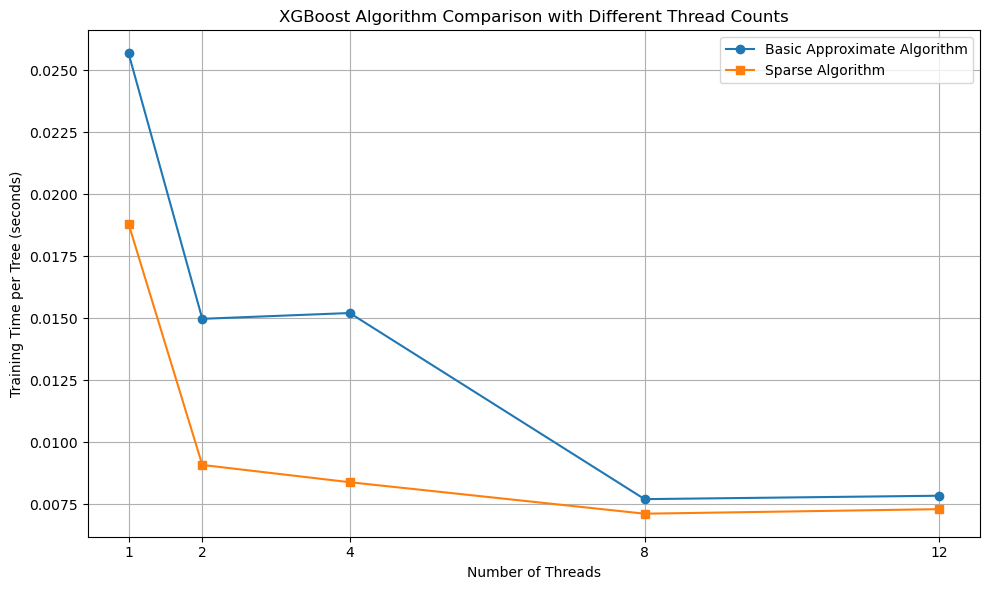

In [16]:
import xgboost as xgb
import time
import matplotlib.pyplot as plt
import numpy as np

params = {
    'max_depth': 5,
    'reg_lambda': 1.0,
    'gamma': 0.1,
    'min_child_weight': 1,
    'colsample_bynode': 0.8,
    'subsample': 0.8,
    'learning_rate': 0.1
}
rounds = 5

np.random.seed(42)
threads_range = [1,2,4,8,12]

results = {
    'approx': [],
    'sparse': []
}

for n_threads in threads_range:
    print(f"Testing with {n_threads} threads...")
    
    xgb_params_approx = {
        'max_depth': params['max_depth'],
        'lambda': params['reg_lambda'],
        'gamma': params['gamma'],
        'min_child_weight': params['min_child_weight'],
        'colsample_bynode': params['colsample_bynode'],
        'subsample': params['subsample'],
        'eta': params['learning_rate'],
        'tree_method': 'approx',
        'nthread': n_threads,
        'objective': 'reg:squarederror'
    }
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    
    start_time = time.time()
    xgb_model = xgb.train(xgb_params_approx, dtrain, num_boost_round=rounds)
    approx_time = (time.time() - start_time) / rounds
    results['approx'].append(approx_time)
    
    xgb_params_sparse = {
        'max_depth': params['max_depth'],
        'lambda': params['reg_lambda'],
        'gamma': params['gamma'],
        'min_child_weight': params['min_child_weight'],
        'colsample_bynode': params['colsample_bynode'],
        'subsample': params['subsample'],
        'eta': params['learning_rate'],
        'tree_method': 'hist',
        'sparse_threshold': 0.2,
        'nthread': n_threads,
        'objective': 'reg:squarederror'
    }
    
    start_time = time.time()
    xgb_model = xgb.train(xgb_params_sparse, dtrain, num_boost_round=rounds)
    sparse_time = (time.time() - start_time) / rounds
    results['sparse'].append(sparse_time)
    
plt.figure(figsize=(10, 6))
plt.plot(threads_range, results['approx'], marker='o', label='Basic Approximate Algorithm')
plt.plot(threads_range, results['sparse'], marker='s', label='Sparse Algorithm')

plt.xlabel('Number of Threads')
plt.ylabel('Training Time per Tree (seconds)')
plt.title('Original XGBoost Codes for Sparse split algorithm')
plt.xticks(threads_range)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Test accuracy on Allstate dataset

In [9]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [10]:
# 在验证集上进行预测和评估
if isinstance(X_val, csr_matrix):
    X_val.data = X_val.data.astype(np.float32)
else:
    X_val = csr_matrix(X_val)
    X_val.data = X_val.data.astype(np.float32)

n_samples = min(10000, min(X_val.shape[0], len(y_val)))  # 确保不超过 y_val 的长度
random_indices = np.random.choice(min(X_val.shape[0], len(y_val)), n_samples, replace=False)

# 对稀疏矩阵和标签进行索引
X_val_subset = X_val[random_indices, :]
y_val_subset = np.array(y_val)[random_indices]

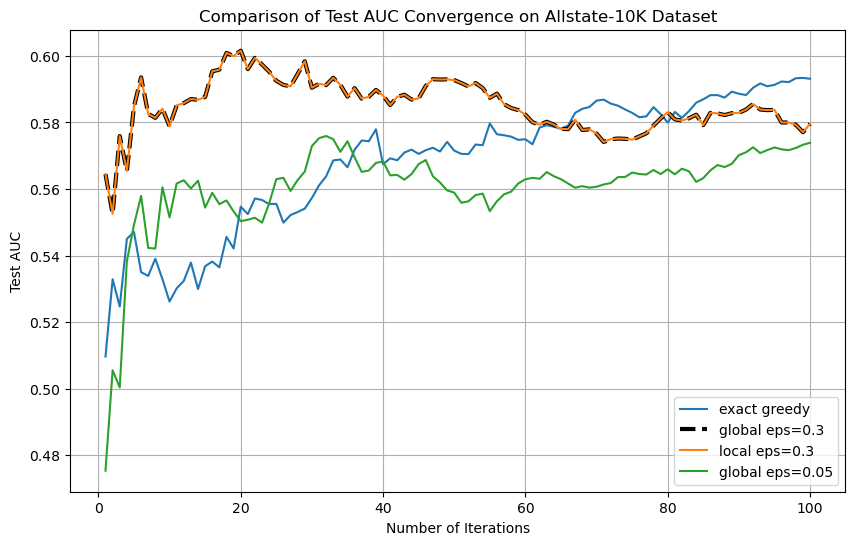

In [29]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

configs = [
    {'name': 'exact greedy', 'tree_method': 'exact'},
    {'name': 'global eps=0.3', 'tree_method': 'approx', 'grow_policy': 'depthwise', 'max_bin': 4}, # sketch_eps is replaced by max_bin, the number of buckets
    {'name': 'local eps=0.3', 'tree_method': 'approx', 'grow_policy': 'lossguide', 'max_bin': 4},
    {'name': 'global eps=0.05', 'tree_method': 'approx', 'grow_policy': 'depthwise', 'max_bin': 20}
]

auc_history = {}
num_round = 100 

for config in configs:
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'tree_method': config['tree_method']
    }
    if config['tree_method'] == 'approx':
        params['grow_policy'] = config['grow_policy']
        params['max_bin'] = config['max_bin']
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_val_subset, label=y_val_subset)
    
    evals_result = {}
    bst = xgb.train(params, dtrain, num_round, evals=[(dtest, 'test')], 
                    evals_result=evals_result, verbose_eval=False)
    
    auc_history[config['name']] = evals_result['test']['auc']

plt.figure(figsize=(10, 6))
for name, aucs in auc_history.items():
    if name=='global eps=0.3':
        plt.plot(range(1, len(aucs) + 1), aucs, label=name, linestyle='--', color='black', linewidth=3)
        continue
    plt.plot(range(1, len(aucs) + 1), aucs, label=name)
    
    
plt.xlabel('Number of Iterations')
plt.ylabel('Test AUC')
plt.title('Comparison of Test AUC Convergence on Allstate-10K Dataset')
plt.legend()
plt.grid(True)
plt.show()